In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

2024-08-04 11:43:45.620963: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-04 11:43:45.623405: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-04 11:43:45.632184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 11:43:45.647941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 11:43:45.652273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 11:43:45.663588: I tensorflow/core/platform/cpu_feature_gu

In [2]:
EMPRESA = 'WEGE3.SA'

In [3]:
def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    data_hist['tomorrow'] = data_hist['Close'].shift(-1)
    return data_hist

In [4]:
def split_df_X_y(df_model):
    dates = df_model.index
    df_as_np = df_model.to_numpy()
    X = df_as_np[:,:-1]

    X = X.reshape(len(dates), X.shape[1], 1)
    y = df_as_np[:,-1]

    return (dates, X.astype(np.float32), y.astype(np.float32))

df_full = get_data_ticker(EMPRESA, period='max')
df = df_full.dropna()
dates, X, y = split_df_X_y(df)

[*********************100%%**********************]  1 of 1 completed


In [5]:
dates

DatetimeIndex(['2000-01-31', '2000-02-01', '2000-02-02', '2000-02-03',
               '2000-02-04', '2000-02-07', '2000-02-08', '2000-02-09',
               '2000-02-10', '2000-02-11',
               ...
               '2024-07-19', '2024-07-22', '2024-07-23', '2024-07-24',
               '2024-07-25', '2024-07-26', '2024-07-29', '2024-07-30',
               '2024-07-31', '2024-08-01'],
              dtype='datetime64[ns]', name='Date', length=6154, freq=None)

In [6]:
def train_model_lstm(X_train, y_train, X_test, y_test):
    model = Sequential([layers.Input((6,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_feedforward(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=6))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Input((6,1)))
    model.add(layers.SimpleRNN(40, return_sequences=True))
    model.add(layers.SimpleRNN(40))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_cnn(X_train, y_train, X_test, y_test):
    # Create a CNN model
    model = Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

In [7]:
def predict_tomorrow(model):
    last_day = get_data_ticker(EMPRESA, period='1mo') # Buscando um mes de dados pois as vezes quando coloco '1d' vem vazio :(
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(last_day)
    return model.predict(np.array([X_tomorrow[-1]]))


In [8]:
range_80 = int(len(dates)*.85)
range_90 = int(len(dates)*.95)

dates_train, X_train, y_train = dates[:range_80], X[:range_80], y[:range_80]
dates_test, X_test, y_test = dates[range_80:range_90], X[range_80:range_90], y[range_80:range_90]
dates_validation, X_validation, y_validation = dates[range_90:], X[range_90:], y[range_90:]

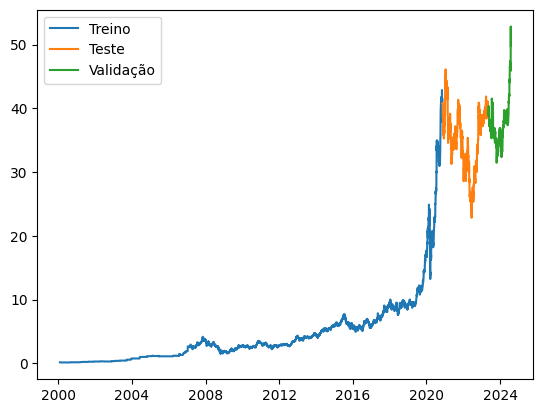

In [9]:
plt.plot(dates_train,y_train, label='Treino')
plt.plot(dates_test,y_test, label='Teste')
plt.plot(dates_validation,y_validation, label='Validação')
plt.legend()

## Treinamento da LSTM

## Resultado com dados nunca vistos pelo modelo

In [10]:
model_lstm = train_model_lstm(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_lstm)

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 23.9581 - mean_absolute_error: 2.1406 - val_loss: 6.4892 - val_mean_absolute_error: 1.9741
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2687 - mean_absolute_error: 0.2052 - val_loss: 2.3304 - val_mean_absolute_error: 1.1638
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2029 - mean_absolute_error: 0.2038 - val_loss: 1.9147 - val_mean_absolute_error: 1.0807
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2079 - mean_absolute_error: 0.2135 - val_loss: 3.8020 - val_mean_absolute_error: 1.6842
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1273 - mean_absolute_error: 0.1618 - val_loss: 2.6286 - val_mean_absolute_error: 1.3165
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1235 - mean_absolute_error: 0.1571 - val_loss: 1.6178 - val_mean_absolute_error: 0.9725
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1188 - mean_absolute_error: 0.

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


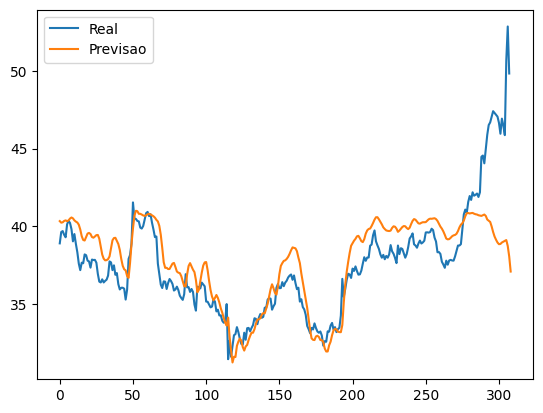

In [11]:
y_pred = model_lstm.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred), label="Previsao")
plt.legend()

In [12]:
model_feedforward = train_model_feedforward(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_feedforward)

Epoch 1/100


/home/nikolas/.local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 15.8377 - mean_absolute_error: 1.5150 - val_loss: 0.8595 - val_mean_absolute_error: 0.6985
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0587 - mean_absolute_error: 0.1116 - val_loss: 1.2349 - val_mean_absolute_error: 0.8955
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0681 - mean_absolute_error: 0.1039 - val_loss: 1.8931 - val_mean_absolute_error: 1.1720
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0561 - mean_absolute_error: 0.1020 - val_loss: 1.0355 - val_mean_absolute_error: 0.8089
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0611 - mean_absolute_error: 0.0925 - val_loss: 0.9048 - val_mean_absolute_error: 0.7460
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0625 - mean_absolute_error: 0.0976 - val_loss: 1.4393 - val_mean_absolute_error: 0.9964
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0600 - mean_absolute_error: 0.1005 - val_l

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


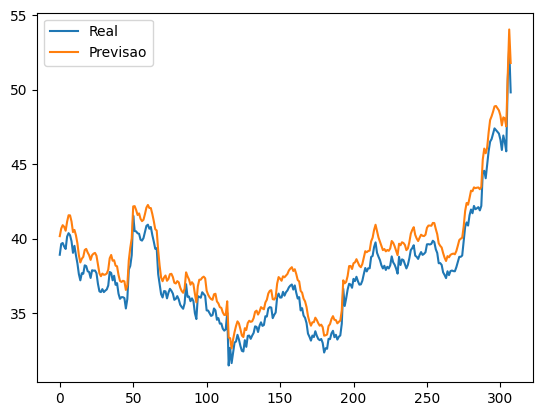

In [18]:
y_pred = model_feedforward.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

In [14]:
model_rnn = train_model_rnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_rnn)

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 26.1591 - mean_absolute_error: 2.0125 - val_loss: 643.2369 - val_mean_absolute_error: 24.9213
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.6593 - mean_absolute_error: 0.8058 - val_loss: 471.2915 - val_mean_absolute_error: 21.1928
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2295 - mean_absolute_error: 0.5577 - val_loss: 343.6620 - val_mean_absolute_error: 17.9307
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6215 - mean_absolute_error: 0.4482 - val_loss: 256.9773 - val_mean_absolute_error: 15.3244
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.6265 - mean_absolute_error: 0.3981 - val_loss: 190.2317 - val_mean_absolute_error: 12.9658
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7970 - mean_absolute_error: 0.3503 - val_loss: 143.5632 - val_mean_absolute_error: 11.0269
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9525 - mean

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


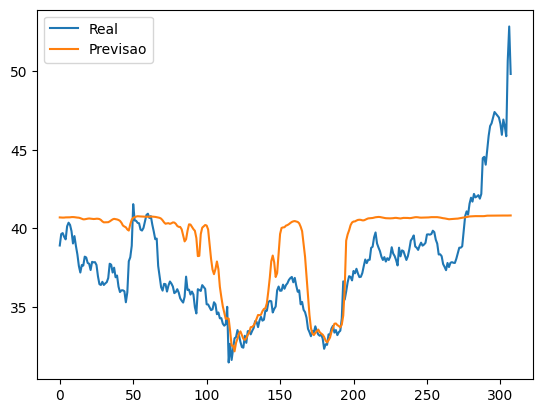

In [15]:
y_pred = model_rnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

In [16]:
model_cnn = train_model_cnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_cnn)

Epoch 1/100


/home/nikolas/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 16.0508 - mean_absolute_error: 1.7189 - val_loss: 1.2160 - val_mean_absolute_error: 0.8500
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1216 - mean_absolute_error: 0.1396 - val_loss: 1.1899 - val_mean_absolute_error: 0.8329
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0909 - mean_absolute_error: 0.1177 - val_loss: 1.8393 - val_mean_absolute_error: 1.0869
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1067 - mean_absolute_error: 0.1264 - val_loss: 1.2960 - val_mean_absolute_error: 0.8739
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0960 - mean_absolute_error: 0.1179 - val_loss: 1.5561 - val_mean_absolute_error: 0.9843
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0878 - mean_absolute_error: 0.1149 - val_loss: 1.2623 - val_mean_absolute_error: 0.8621
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0860 - mean_absolute_error: 0.1202 - val_l

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


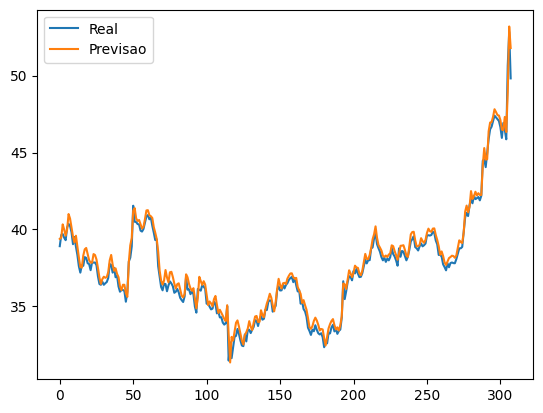

In [17]:
y_pred = model_cnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()